<a href="https://colab.research.google.com/github/Sinem-B62/retail_demand_analysis/blob/main/2_guayas_prepared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ziel des Projekts ist die Entwicklung eines Machine-Learning-Modells zur Vorhersage der täglichen Verkaufsnachfrage für jedes Produkt in allen Filialen der Provinz Guayas.**

In [49]:
!pip install -U gdown

import pandas as pd
import requests
import io


# Erstellen Sie die direkte Download-URL aus einer Datei-ID.
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Hilfsfunktion zum Laden einer CSV-Datei über eine direkte URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Löst einen Fehler aus, wenn die Anfrage fehlschlägt.
    return pd.read_csv(io.StringIO(response.text))

    # Verzeichnis der Datei-IDs zur besseren Übersichtlichkeit
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


# **📝 Überprüfung der Region - Guayas**

Der Datensatz wurde mit den Filialinformationen verknüpft, um sicherzustellen, dass alle Einträge aus der Provinz Guayas stammen.

In [50]:
import pandas as pd

# Pfad zu deiner Datei (aus Google Drive)
path = '/content/drive/MyDrive/Data Science Sinem/Time Series/df_train_filtered_top3_final.pkl'

# Datei laden
df_train = pd.read_pickle(path)

print(f"✅ Datei geladen: {len(df_train):,} Zeilen und {len(df_train.columns)} Spalten")
df_train.head()


✅ Datei geladen: 17,455,672 Zeilen und 12 Spalten


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-17,622071,24,96995,2.0,False,7.867965,2013,1,17,3,2.000000
1,2013-01-18,0,24,96995,0.0,False,-0.112399,2013,1,18,4,1.000000
2,2013-01-19,0,24,96995,0.0,False,-0.112399,2013,1,19,5,0.666667
3,2013-01-20,0,24,96995,0.0,False,-0.112399,2013,1,20,6,0.500000
4,2013-01-21,0,24,96995,0.0,False,-0.112399,2013,1,21,0,0.400000


In [51]:
df_stores.head()
print(df_stores.columns)


Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')


In [52]:
# Verknüpfen der Verkaufsdaten mit den Filialinformationen
df_merged = df_train.merge(df_stores[['store_nbr', 'state']], on='store_nbr', how='left')

print(f"✅ Nach Merge: {len(df_merged):,} Zeilen, {len(df_merged.columns)} Spalten")
df_merged.head()


✅ Nach Merge: 17,455,672 Zeilen, 13 Spalten


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg,state
0,2013-01-17,622071,24,96995,2.0,False,7.867965,2013,1,17,3,2.000000,Guayas
1,2013-01-18,0,24,96995,0.0,False,-0.112399,2013,1,18,4,1.000000,Guayas
2,2013-01-19,0,24,96995,0.0,False,-0.112399,2013,1,19,5,0.666667,Guayas
3,2013-01-20,0,24,96995,0.0,False,-0.112399,2013,1,20,6,0.500000,Guayas
4,2013-01-21,0,24,96995,0.0,False,-0.112399,2013,1,21,0,0.400000,Guayas


In [53]:
print(df_merged['state'].value_counts())


state
Guayas    17455672
Name: count, dtype: int64


# **📝 Filterung auf die Top-3-Familien**

Um die Analyse gezielt auf die wichtigsten Produktgruppen zu konzentrieren, wird der Datensatz auf die drei häufigsten Familien „GROCERY I“, „BEVERAGES“ und „CLEANING“ eingeschränkt.

In [54]:
df_items

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1
...,...,...,...,...
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0
4098,2134058,BEVERAGES,1124,0


In [55]:
# Definieren der Top-3-Familien
top_families = ['GROCERY I', 'BEVERAGES', 'CLEANING']

# item_nbr der Top-3-Familien auswählen
item_ids = df_items[df_items['family'].isin(top_families)]['item_nbr'].unique()

# Trainingsdaten filtern
df_train_filtered = df_train[df_train['item_nbr'].isin(item_ids)]

# Kontrolle
print(f"✅ Gefilterte Daten: {len(df_train_filtered):,} Zeilen")
print(df_items['family'].value_counts())


✅ Gefilterte Daten: 17,455,672 Zeilen
family
GROCERY I                     1334
BEVERAGES                      613
CLEANING                       446
PRODUCE                        306
DAIRY                          242
PERSONAL CARE                  153
BREAD/BAKERY                   134
HOME CARE                      108
DELI                            91
MEATS                           84
HOME AND KITCHEN I              77
LIQUOR,WINE,BEER                73
FROZEN FOODS                    55
POULTRY                         54
HOME AND KITCHEN II             45
EGGS                            41
CELEBRATION                     31
LAWN AND GARDEN                 26
PREPARED FOODS                  26
LADIESWEAR                      21
LINGERIE                        20
AUTOMOTIVE                      20
BEAUTY                          19
PLAYERS AND ELECTRONICS         17
SCHOOL AND OFFICE SUPPLIES      15
GROCERY II                      14
PET SUPPLIES                    14
SEAFOOD   

In [56]:
df_train_filtered

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-17,622071,24,96995,2.0,False,7.867965,2013,1,17,3,2.000000
1,2013-01-18,0,24,96995,0.0,False,-0.112399,2013,1,18,4,1.000000
2,2013-01-19,0,24,96995,0.0,False,-0.112399,2013,1,19,5,0.666667
3,2013-01-20,0,24,96995,0.0,False,-0.112399,2013,1,20,6,0.500000
4,2013-01-21,0,24,96995,0.0,False,-0.112399,2013,1,21,0,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
17455667,2017-07-30,0,51,2089224,0.0,False,-0.261634,2017,7,30,6,0.000000
17455668,2017-07-31,0,51,2089224,0.0,False,-0.261634,2017,7,31,0,0.000000
17455669,2017-08-01,124029577,51,2089224,1.0,False,1.308170,2017,8,1,1,0.142857
17455670,2017-06-24,120014301,51,2089339,1.0,False,0.000000,2017,6,24,5,1.000000


## Der Datensatz wird auf das erste Quartal 2014 **(1. Januar bis 31. März)** begrenzt, um einen überschaubaren Zeitraum für das Modelltraining zu verwenden.

In [57]:
# Zeitraum definieren
start_date = '2014-01-01'
end_date = '2014-03-31'

df_train_filtered = df_train_filtered[
    (df_train_filtered['date'] >= start_date) &
    (df_train_filtered['date'] <= end_date)
]

In [58]:
df_train_filtered

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg
1223,2014-01-01,0,24,103520,0.0,False,-0.075155,2014,1,1,2,0.00
1224,2014-01-02,0,24,103520,0.0,False,-0.075155,2014,1,2,3,0.00
1225,2014-01-03,0,24,103520,0.0,False,-0.075155,2014,1,3,4,0.00
1226,2014-01-04,0,24,103520,0.0,False,-0.075155,2014,1,4,5,0.00
1227,2014-01-05,0,24,103520,0.0,False,-0.075155,2014,1,5,6,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
17311019,2014-03-31,0,51,1464218,0.0,False,-0.093183,2014,3,31,0,0.00
17313171,2014-03-28,21454791,51,1464239,3.0,False,5.585169,2014,3,28,4,3.00
17313172,2014-03-29,0,51,1464239,0.0,False,-0.084067,2014,3,29,5,1.50
17313173,2014-03-30,0,51,1464239,0.0,False,-0.084067,2014,3,30,6,1.00


## Im Rahmen des Feature Engineerings werden zeitbasierte Merkmale (Jahr, Monat, Wochentag), Lag-Features und gleitende Durchschnitte erstellt, um Trends und saisonale Effekte für XGBoost sichtbar zu machen.

In [59]:
# 🔹 Lag-Features (Verzögerungen) erstellen — vergangene Verkaufswerte
df_train_filtered = df_train_filtered.sort_values(['store_nbr', 'item_nbr', 'date'])

df_train_filtered['lag_1'] = df_train_filtered['unit_sales'].shift(1)
df_train_filtered['lag_7'] = df_train_filtered['unit_sales'].shift(7)
df_train_filtered['lag_30'] = df_train_filtered['unit_sales'].shift(30)


df_train_filtered['rolling_std_7'] = df_train_filtered['unit_sales'].shift(1).rolling(window=7).std()

# 🔹 Fehlende Werte nach Shifts auffüllen (optional)
df_train_filtered = df_train_filtered.fillna(0)

# Kontrolle
print("✅ Neue Features hinzugefügt:")
print(df_train_filtered.columns)
df_train_filtered

✅ Neue Features hinzugefügt:
Index(['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg',
       'lag_1', 'lag_7', 'lag_30', 'rolling_std_7'],
      dtype='object')


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg,lag_1,lag_7,lag_30,rolling_std_7
1223,2014-01-01,0,24,103520,0.0,False,-0.075155,2014,1,1,2,0.00,0.0,0.0,0.0,0.000000
1224,2014-01-02,0,24,103520,0.0,False,-0.075155,2014,1,2,3,0.00,0.0,0.0,0.0,0.000000
1225,2014-01-03,0,24,103520,0.0,False,-0.075155,2014,1,3,4,0.00,0.0,0.0,0.0,0.000000
1226,2014-01-04,0,24,103520,0.0,False,-0.075155,2014,1,4,5,0.00,0.0,0.0,0.0,0.000000
1227,2014-01-05,0,24,103520,0.0,False,-0.075155,2014,1,5,6,0.00,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17311019,2014-03-31,0,51,1464218,0.0,False,-0.093183,2014,3,31,0,0.00,0.0,0.0,0.0,0.000000
17313171,2014-03-28,21454791,51,1464239,3.0,False,5.585169,2014,3,28,4,3.00,0.0,0.0,0.0,0.000000
17313172,2014-03-29,0,51,1464239,0.0,False,-0.084067,2014,3,29,5,1.50,3.0,0.0,0.0,1.133893
17313173,2014-03-30,0,51,1464239,0.0,False,-0.084067,2014,3,30,6,1.00,0.0,0.0,0.0,1.133893


In [60]:

# Mit df_stores zusammenführen (nach store_nbr)
df_merged = df_train_filtered.merge(df_stores, on='store_nbr', how='left')

# Mit df_items zusammenführen (nach item_nbr)
df_merged = df_merged.merge(df_items, on='item_nbr', how='left')

# 3️⃣ Kontrolle: Überblick über den neuen Datensatz
print("✅ Daten erfolgreich zusammengeführt!")
print(f"➡️ Zeilen: {len(df_merged):,}")
print(f"➡️ Spalten: {len(df_merged.columns)}")
print("\n🧠 Neue Spaltenbeispiele:")
print(df_merged.columns.tolist()[:15])  # Zeigt die ersten Spaltennamen
print("\n📊 Stichprobe:")
display(df_merged.head(3))


✅ Daten erfolgreich zusammengeführt!
➡️ Zeilen: 798,003
➡️ Spalten: 23

🧠 Neue Spaltenbeispiele:
['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'z_score', 'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg', 'lag_1', 'lag_7', 'lag_30']

📊 Stichprobe:


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,...,lag_7,lag_30,rolling_std_7,city,state,type,cluster,family,class,perishable
0,2014-01-01,0,24,103520,0.0,False,-0.075155,2014,1,1,...,0.0,0.0,0.0,Guayaquil,Guayas,D,1,GROCERY I,1028,0
1,2014-01-02,0,24,103520,0.0,False,-0.075155,2014,1,2,...,0.0,0.0,0.0,Guayaquil,Guayas,D,1,GROCERY I,1028,0
2,2014-01-03,0,24,103520,0.0,False,-0.075155,2014,1,3,...,0.0,0.0,0.0,Guayaquil,Guayas,D,1,GROCERY I,1028,0


# **Aufteilung Training/Test**

In [61]:

df_train_filtered['date'] = pd.to_datetime(df_train_filtered['date'])


df_train_filtered = df_train_filtered.sort_values('date').reset_index(drop=True)


train_start = '2014-01-01'
train_end   = '2014-02-28'
test_start  = '2014-03-01'
test_end    = '2014-03-31'


train_mask = (df_train_filtered['date'] >= train_start) & (df_train_filtered['date'] <= train_end)
test_mask  = (df_train_filtered['date'] >= test_start) & (df_train_filtered['date'] <= test_end)


df_train = df_train_filtered.loc[train_mask].reset_index(drop=True)
df_test  = df_train_filtered.loc[test_mask].reset_index(drop=True)


print("Trainingsdaten:", len(df_train), "Zeilen von", df_train['date'].min(), "bis", df_train['date'].max())
print("Testdaten:", len(df_test), "Zeilen von", df_test['date'].min(), "bis", df_test['date'].max())


Trainingsdaten: 513425 Zeilen von 2014-01-01 00:00:00 bis 2014-02-28 00:00:00
Testdaten: 284578 Zeilen von 2014-03-01 00:00:00 bis 2014-03-31 00:00:00


In [62]:
target_col = 'unit_sales'

feature_cols = [
    'store_nbr',
    'item_nbr',
    'onpromotion',
    'z_score',
    'year',
    'month',
    'day_of_week',
    'unit_sales_7d_avg'
]

# 🔹 Trainingsdaten trennen
X_train = df_train[feature_cols]
y_train = df_train[target_col]

# 🔹 Testdaten trennen
X_test = df_test[feature_cols]
y_test = df_test[target_col]

# 🔹 Kontrolle
print("Feature-Matrix (Train):", X_train.shape)
print("Target (Train):", y_train.shape)
print("Feature-Matrix (Test):", X_test.shape)
print("Target (Test):", y_test.shape)


Feature-Matrix (Train): (513425, 8)
Target (Train): (513425,)
Feature-Matrix (Test): (284578, 8)
Target (Test): (284578,)


# **XGBoost Modelaufbau**

In [63]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#  Kontrolle
print("✅ Modell trainiert! Anzahl Vorhersagen:", len(y_pred))


✅ Modell trainiert! Anzahl Vorhersagen: 284578


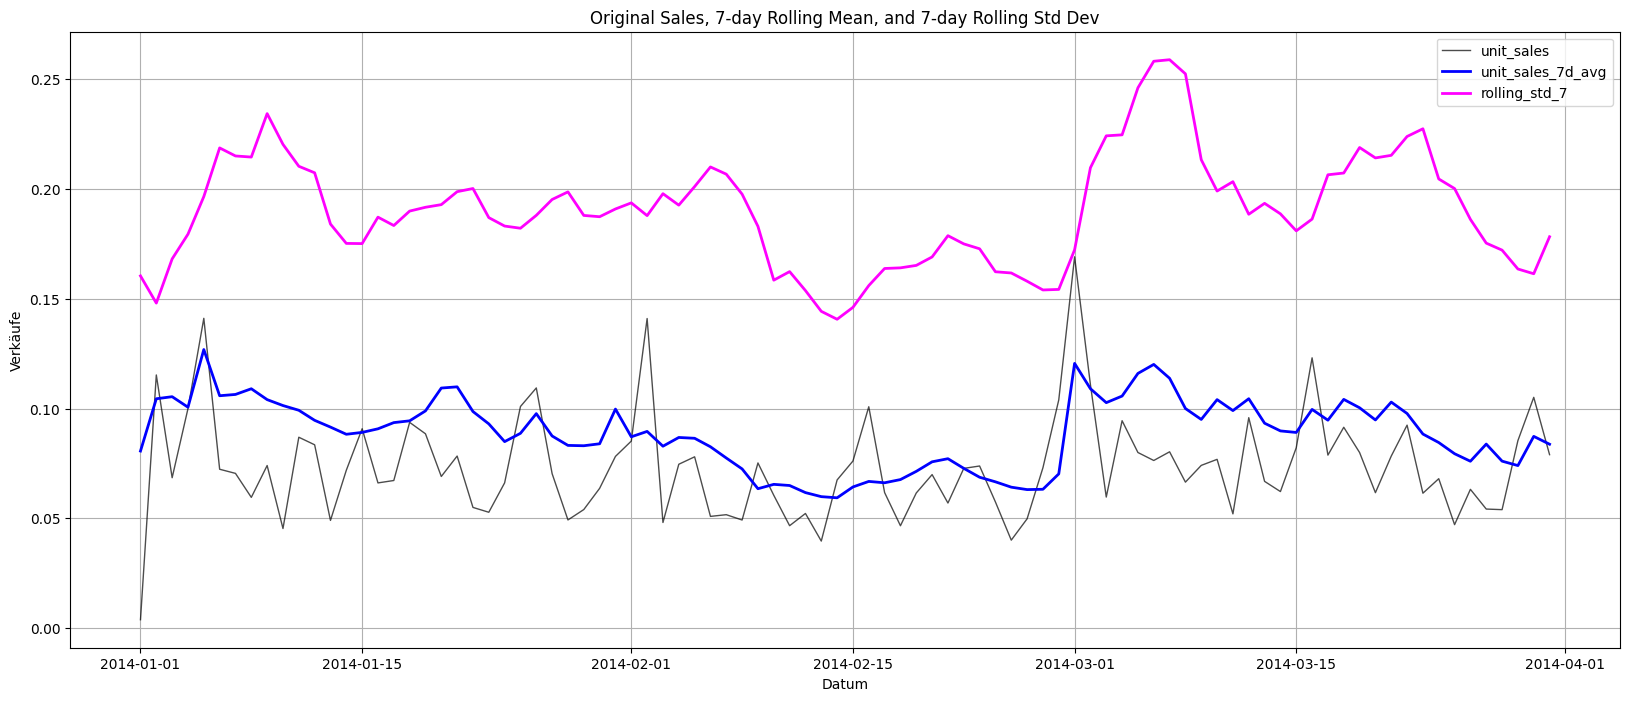

In [64]:
import matplotlib.pyplot as plt


daily_sales = df_train_filtered.groupby('date')[['unit_sales', 'unit_sales_7d_avg', 'rolling_std_7']].mean()

plt.figure(figsize=(20, 8))
plt.plot(daily_sales.index, daily_sales['unit_sales'], label='unit_sales', color='black',linewidth=1, alpha=0.7)
plt.plot(daily_sales.index, daily_sales['unit_sales_7d_avg'], label='unit_sales_7d_avg', linewidth=2,  color='blue')
plt.plot(daily_sales.index, daily_sales['rolling_std_7'], label='rolling_std_7', linewidth=2,  color='magenta')
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.xlabel('Datum')
plt.ylabel('Verkäufe')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
from sklearn.metrics import mean_absolute_error

# y_test and y_pred are Pandas Series aligned by date
mae  = mean_absolute_error(y_test, y_pred)

print(f"MAE   : {mae:.3f} units")

MAE   : 0.026 units


# **LSMT**

In [66]:
# 📚 Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


values = df_train_filtered['unit_sales'].values.reshape(-1, 1)

# Train-Test-Split (chronologisch)
train_size = int(len(values) * 0.8)
train, test = values[:train_size], values[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# 🪄 2️⃣ Sequenzen erstellen (Fenstergröße = 30)
SEQ_LEN = 30

def make_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_scaled, SEQ_LEN)
X_test, y_test = make_sequences(test_scaled, SEQ_LEN)

print("✅ Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# 🧠 3️⃣ Modell definieren
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')

# 🚀 4️⃣ Trainieren
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# 🔮 5️⃣ Vorhersagen machen
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 📈 6️⃣ Plot: Tatsächlich vs. Vorhergesagt
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Tatsächliche Verkäufe', linewidth=2)
plt.plot(y_pred, label='LSTM-Vorhersage', linewidth=2, alpha=0.8)
plt.title("LSTM – Tatsächliche vs. Vorhergesagte Verkäufe")
plt.xlabel("Zeit (Tage)")
plt.ylabel("unit_sales")
plt.legend()
plt.tight_layout()
plt.show()


✅ Shapes:
X_train: (638372, 30, 1) y_train: (638372, 1)
X_test: (159571, 30, 1) y_test: (159571, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
17955/17955 ━━━━━━━━━━━━━━━━━━━━ 312s 17ms/step - loss: 4.7309e-04 - val_loss: 3.8857e-04
Epoch 2/20
 9655/17955 ━━━━━━━━━━━━━━━━━━━━ 2:15 16ms/step - loss: 4.3228e-04

KeyboardInterrupt: 